# Self Supervised Learning & Few-Shot Evaluation

## Self Supervised Learning 🏫
I've been studying a lot about Self-Supervised Learning (SSL) methods like `SimCLR` and `DINO`🦖. `SimCLR` uses a contrastive loss that groups _views_ of the same images to learn what it means to be a specific class; in _contrast_, `DINO` was trained using self-distillation (i.e. teaches itself!) without labels.

I found these methods interesting because SSL wasn't a big focus when I took CPSC 340, but that makes sense - a good chunk of the time we'll have some labelled data. However, being familiar with the clinical field and having done a histopathology project, I realize this is a big problem in medical data: there's often not enough labels. That said, a good SSL method that can classify would be a huge boon, allowing us to reduce the need for labelling.

## Meta-Learning (Prototypes) ⚽
On the other hand, I was also looking at Meta-Learning. This topic is not often discussed, but has some interesting applications; consider having a huge database of images of common cancer diagnoses, is there a way to effectively classify _new_ varieties if I never trained on them? One basic network I read up on is `ProtoNet` and how **few-shot** classification is evaluated.

A model that can be applied to new domains would be great because it could:
- 🕛 save on re-training time,
- 💯 potentially get good classification accuracy with a smaller dataset,
- 🔢 allow us to use the same model for more than one thing

I also learned that prototypical networks like ProtoNet teaches its encoder to learn by support/query batches. This makes me wonder what happens if I chuck a pre-trained encoder. Granted that I worked through [UvA], I borrowed some code there. Thus, I also trained my ProtoNet backbone using a typical convnet (i.e. DenseNet).

## Questions 🔍
This led to a couple themes and questions I wanted to solve in this little research:
1. Modern SSL and classification:
    - How do some modern SSL methods compare in classification tasks?
    - Can a model trained on a dataset work (e.g. `SimCLR`) better than a huge generalist model (`DINO`)
2. Prototypical networks:
    - How effective is the prototype algorithm in cross-domain knowledge (hiccups talked in following sections)
    - Does initializing ProtoNet with a pre-trained encoder improve cross-domain performance compared to training from scratch?

As you go through this notebook, you will see some notes scattered throughout which reflects the thoughts had during certain sections of the notebook.

## Housekeeping Notes 📝
- Models trained to reasonable lengths, see the training notebook for more comments
- I pulled embeddings using validation set because I did not have enough
- I did not perform the normal N-way K-shot validation (using hidden classes of original dataset) cause a mistake, notes below

## Resources 📚
- Meta-Learning [(Phillip Lippe @ UvA)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial16/Meta_Learning.html)
- SSL Contrastive Learning [(Phillip Lippe @ UvA)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html)
- Prototypical Networks for Few-shot Learning [(Snell et al., 2017)](https://www.cs.toronto.edu/~zemel/documents/prototypical_networks_nips_2017.pdf)
- A Cross-Domain Few-Shot Learning Method Based on Domain Knowledge Mapping [(Chen et al., 2025)](https://arxiv.org/abs/2504.06608)
- Revisiting Prototypical Network for Cross Domain Few-Shot Learning [(Zhou et al., 2023)](https://openaccess.thecvf.com/content/CVPR2023/papers/Zhou_Revisiting_Prototypical_Network_for_Cross_Domain_Few-Shot_Learning_CVPR_2023_paper.pdf)
- MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification [(Yang et al., 2023)](https://medmnist.com/)
- MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis [(Yang et al., 2021)](https://medmnist.com/)
- A large histological images dataset of gastric cancer with tumour microenvironment annotation for AI [(Lou et al., 2025)](https://www.nature.com/articles/s41597-025-04489-9)
- DINOv2 [(Meta)](https://github.com/facebookresearch/dinov2)
- YT, the miscellaneous blog posts, and ChatGPT for the tough questions

# Visualization of Embeddings 👀
The data I used is PathMNIST as part of the [MedMNIST dataset](https://medmnist.com/). This is a collection of tissue patches from the colon with 9 classes for classification.

Also, I selected 224x224 as a personal choice, but in retrospect I could maybe have gotten away with something smaller as long as it was acceptable with DINO.

In this section, I visualized some the data as well as the embeddings - cool stuff below!

In [36]:
import tqdm
import torch
import torchvision
import numpy as np
import pandas as pd

# Loaders
from src.dataloaders import *
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Models
from src.models.dino import DinoV2, get_dino_transforms
from src.models.simclr import *
from src.models.protonet import ProtoNet, FewShotBatchSampler, split_batch
from torchvision.models import DenseNet


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Dim reduciton
import umap
from sklearn.manifold import TSNE

# Stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

In [2]:
# Loading some checkpoints and our model backbones

SIMCLR_CHECKPOINT = "checkpoints/SimCLR/epoch=35-val_acc_top1=0.86.ckpt"
CONVNET_CHECKPOINT = "checkpoints/Convnet/epoch=2-val_acc=0.96.ckpt"

OUT_DIM = 128
TRANSFORM = get_dino_transforms() # imagenet

# Load Models
simclr_model = SimCLR.load_from_checkpoint(
    SIMCLR_CHECKPOINT,
    hidden_dim=2048,
    out_dim=OUT_DIM,
    learning_rate=5e-4,
    temperature=0.07,
    weight_decay=1e-4,
    max_epochs=500
)

dino_model = DinoV2(OUT_DIM)

protonet = ProtoNet.load_from_checkpoint(
    CONVNET_CHECKPOINT,
    backbone=DenseNet(
        growth_rate=32,
        block_config=(6, 6, 6, 6),
        bn_size=2,
        num_init_features=64,
        num_classes=128,
    ),
    learning_rate=5e-4
)

backbones = {
    "SimCLR": simclr_model,
    "DinoV2": dino_model,
    "Convnet": protonet.encoder
}

backbones = {
    k: v.eval().to("cuda")
    for k, v in backbones.items()
}

Using cache found in C:\Users\Alvin/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "C:\Users\Alvin\Desktop\prototype-learning\.venv\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'
C:\Users\Alvin/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\Alvin/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\Alvin/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
# Prepare dataset
val_dataset = MNISTData("data/pathmnist_224.npz", "val", TRANSFORM)
dataloader = DataLoader(
    val_dataset,
    batch_size=256,
    num_workers=4,
)

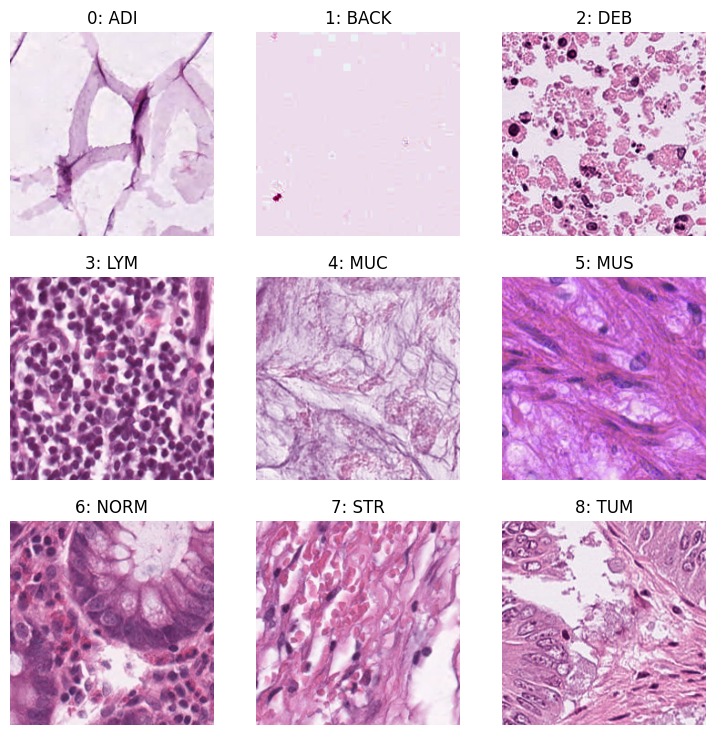

In [4]:
# Peek into dataset

pathmnist_labels = {
    0: "ADI", # Adipose tissue
    1: "BACK", # Background
    2: "DEB", # Debris
    3: "LYM", # Lymphocytes
    4: "MUC", # Mucus
    5: "MUS", # Smooth muscle
    6: "NORM", # Normal colon mucosa
    7: "STR", # Cancer-associated stroma
    8: "TUM", # Colorectal adenocarcinoma epithelium
}

images, labels = next(iter(dataloader))

# # Denormalize
def denormalize(images):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return images * std + mean

images = denormalize(images)

seen = set()
n_unique_labels = len(labels.unique())
class_sample = []

# sketchy in case we load the entire set
for x, y in zip(images, labels):    
    if len(seen) == n_unique_labels:
        break
        
    if int(y) in seen:
        continue

    seen.add(int(y))
    class_sample.append([x, y])
    
class_sample.sort(key=lambda x: x[-1], reverse=True)

# I know it's 9 classes so...3x3
fig, axs = plt.subplots(3, 3, figsize=(9,9))

for i in range(3):
    for j in range(3):
        x, y = class_sample.pop()
        axs[i][j].imshow(x.permute(1, 2, 0))
        axs[i][j].axis("off")
        axs[i][j].set_title(f"{int(y)}: {pathmnist_labels[int(y)]}")
        
plt.show()

## Embeddings 🛏️

One common technique to visualize and interpret what a model is doing when encoding data is to apply dimensionality reduction to the embeddings. This gives us a glimpse into what the model is “looking at.” Here, I played around with two common techniques: t-SNE and UMAP.

This is mostly a qualitative analysis, but it does give some confidence that the mappings make sense.

As I created the UMAP and t-SNE plots, I noticed a few things:
- Classes tend to cluster together when projected to lower dimensions. This suggests that the encoders have learned to represent class similarities in a meaningful way.
- Certain classes consistently end up close to each other across different encoders (e.g., 6 & 8, 5 & 7). I speculate this means the model has picked up on latent structure intrinsic to those tissue types. 

**TODO: I should check if there’s a citation on this - I wonder if this occurs elsewhere**

In [5]:
# Getting the embeddings
from collections import defaultdict

@torch.no_grad()
def extract_embeddings(models, dataloader, normalize=False):
    embeds = defaultdict(list)
    labels = defaultdict(list)

    for x, y in tqdm.tqdm(dataloader, "Extracting Features"):
        x = x.to("cuda")
        
        for k, model in models.items():
            out = model(x)

            # Jank but works
            if isinstance(out, tuple):
                _, h = out
            else:
                h = out

            if normalize:
                h = h / h.norm(dim=1, keepdim=True)
                
            embeds[k].append(h.cpu())
            labels[k].append(y.cpu())

    return {k: (torch.cat(embeds[k]), torch.cat(labels[k])) for k in models.keys()}

embeddings = extract_embeddings(backbones, dataloader)

Extracting Features: 100%|████████████████████████████████████████████| 40/40 [01:14<00:00,  1.85s/it]


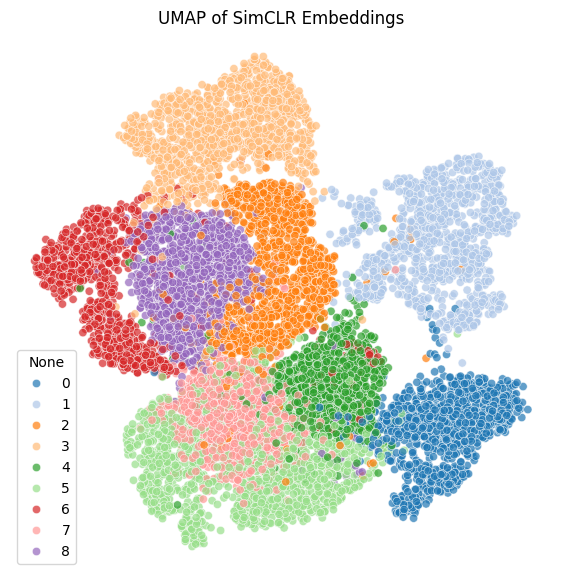

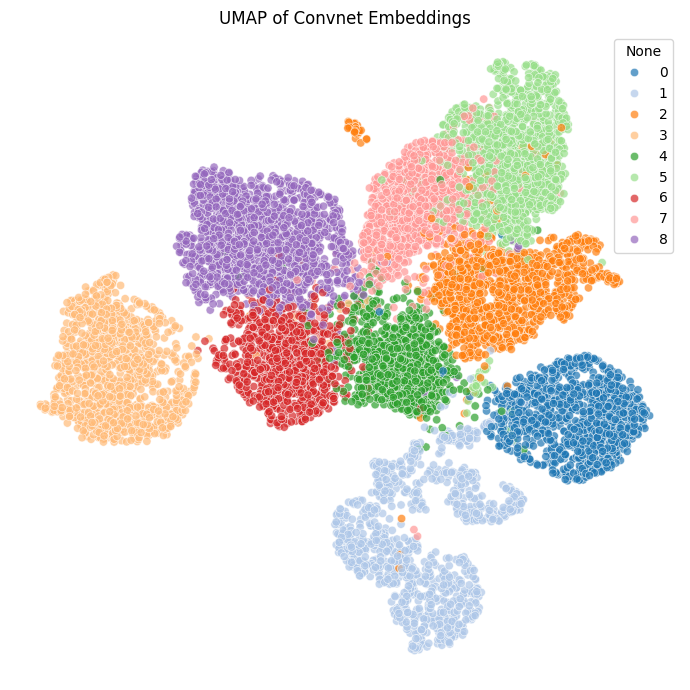

In [8]:
# Plot UMAP
RANDOM_STATE_UMAP = 5301
N_NEIGHBORS = 20
MIN_DIST = 0.8

reducer = umap.UMAP(n_components=2, n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, random_state=RANDOM_STATE_UMAP)
umaps = {k: (reducer.fit_transform(embeds), lbls) for k, (embeds, lbls) in embeddings.items()}


for k, (X, y) in umaps.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    y = y.flatten()
    
    sns.scatterplot(
        x=X[:, 0], 
        y=X[:, 1], 
        ax=ax, 
        hue=y, 
        alpha=0.7, 
        legend=True,
        palette="tab20",
    )

    ax.set_title(f"UMAP of {k} Embeddings")
    ax.axis("off")

fig.tight_layout()

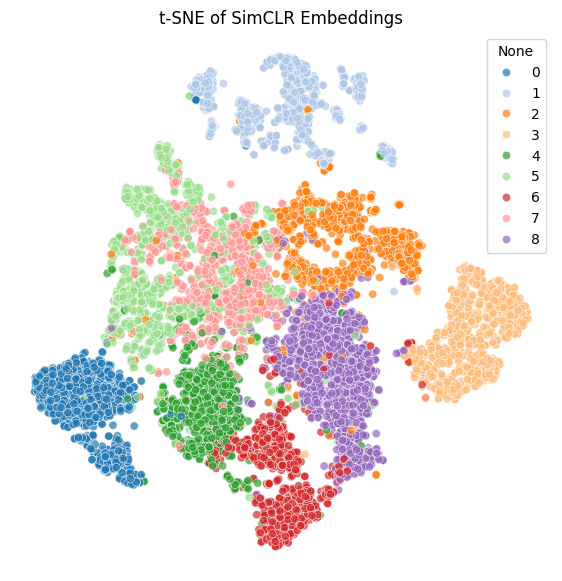

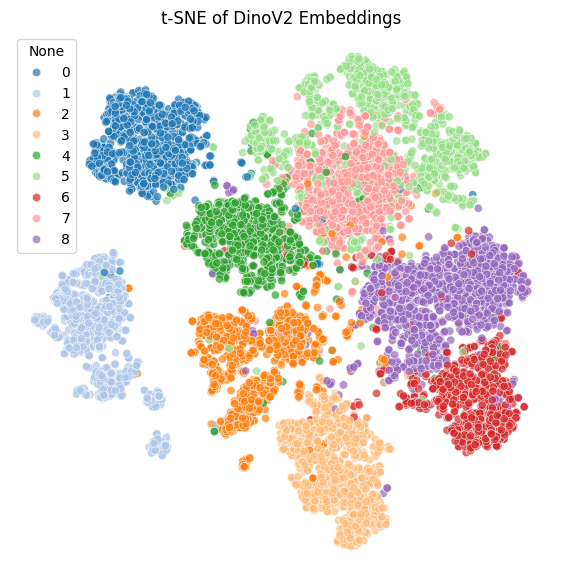

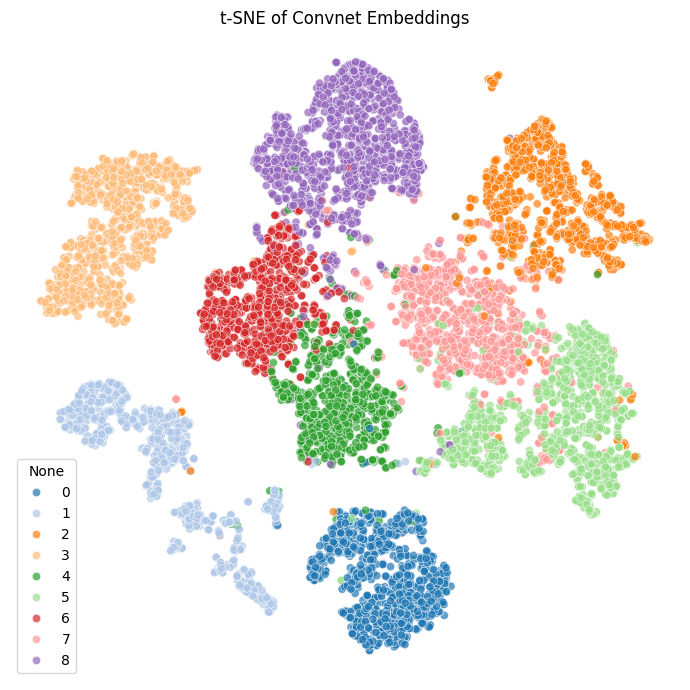

In [14]:
RANDOM_STATE_TSNE = 42
PERPLEXITY = 30

# TSNE
tsne = TSNE(n_components=2, perplexity=PERPLEXITY, random_state=RANDOM_STATE_TSNE)
tsnes = {k: (tsne.fit_transform(embeds), lbls) for k, (embeds, lbls) in embeddings.items()}

# Plot TSNE

for k, (X, y) in tsnes.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    y = y.flatten()

    sns.scatterplot(
        x=X[:, 0], 
        y=X[:, 1], 
        ax=ax, 
        hue=y, 
        alpha=0.7, 
        legend=True,
        palette="tab20",
    )

    ax.set_title(f"t-SNE of {k} Embeddings")
    ax.axis("off")

fig.tight_layout()

## Performance

Here I wanted to answer a few earlier questions:
- How do some modern SSL methods compare in classification tasks?
- Can a model trained on a dataset (e.g., `SimCLR`) perform better than a huge generalist model (`DINO`)?

To get a fair evaluation, I trained a very simple Logistic Regression classifier using the encoders’ embeddings. This lets us measure how linearly separable the classes are; i.e. how well the representations support classification without adding more learnable parameters. 

**Notes on metrics:**
- **Accuracy**: overall proportion of correct predictions.
- **F1**: balance between precision and recall (how often a positive prediction is actually correct).
- **AUC**: ability of the classifier to distinguish between classes (higher means better than random guessing).

| Model   | Accuracy | F1       | AUC     |
|:---------:|----------|----------|---------|
| SimCLR  | 0.890669 | 0.854439 | 0.990274 |
| DinoV2  | 0.909192 | 0.884305 | 0.990328 |
| ConvNet | 0.902368 | 0.875490 | 0.988344 |

The metrics are pretty close. `DINO` performed marginally better across the board, which makes sense...it’s a large distilled foundation model. The main takeaway is that smaller models can still keep up surprisingly well - impressive!

So, back to the questions:
1. **How do some modern SSL methods compare in classification tasks?**  
   - They’re actually quite comparable. The main caveat is training time: `ConvNet` trained very quickly, while `SimCLR` took a few full days. (I’m not sure where `DINO` lands since I used the pretrained encoder.)
2. **Can a model trained on a dataset (e.g., `SimCLR`) perform better than a huge generalist model (`DINO`)?**  
   - Not in this case, `DINO` still edged ahead...but check out the next section! 😉


In [15]:
# Prepare PathMNIST dataset
imagenet_transforms = get_dino_transforms()
test_dataset = MNISTData("data/pathmnist_224.npz", "test", imagenet_transforms)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=256,
    num_workers=4,
)

In [22]:
def get_linear_probe(X_train, y_train):
    """Get linear probe (using logistic regression"""
    y_train = y_train.flatten()
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    return clf
    
def extract_single_embeddings(model, loader, device="cuda"):
    model.eval().to(device)
    feats, labels = [], []
    with torch.no_grad():
        for x, y in tqdm.tqdm(loader):
            x = x.to(device)

            out = model(x)

            if isinstance(out, tuple):
                _, h = out
            else:
                h = out
                
            feats.append(h.cpu())
            labels.append(y.cpu())
    return torch.cat(feats), torch.cat(labels)

def get_preds(clf, backbone, test_dataloader):
    """Predict over test dataset"""
    X_test, y_true  = extract_single_embeddings(backbone, test_dataloader)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    return y_true, y_pred, y_pred_proba

def get_metrics(y_true, y_pred, y_pred_proba):
    """Get evaluation metrics"""
    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # F1
    f1 = f1_score(y_true, y_pred, average="macro")
        
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # ROC
    n_classes = y_pred_proba.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    auc_score = roc_auc_score(
        y_true_bin, 
        y_pred_proba,
        average="macro", 
        multi_class="ovr"
    )

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    
    return {
        "acc": acc, 
        "f1": f1, 
        "auc": auc_score,
        "cm": cm, 
        "roc": (fpr, tpr, roc_auc, y_true_bin)
    }

In [26]:
# Basic linear probing using encoders
# probes = {k: get_linear_probe(*embeds) for k, embeds in embeddings.items()}
# linear_preds = {k: get_preds(probes[k], backbones[k], test_dataloader) for k in probes.keys()}
metrics = {k: get_metrics(*p) for k, p in linear_preds.items()}

pd.DataFrame.from_dict(metrics).loc[["acc", "f1", "auc"]]

SimCLR    DinoV2   Convnet
acc  0.890669  0.909192  0.902368
f1   0.854439  0.884305   0.87549
auc  0.990274  0.990328  0.988344

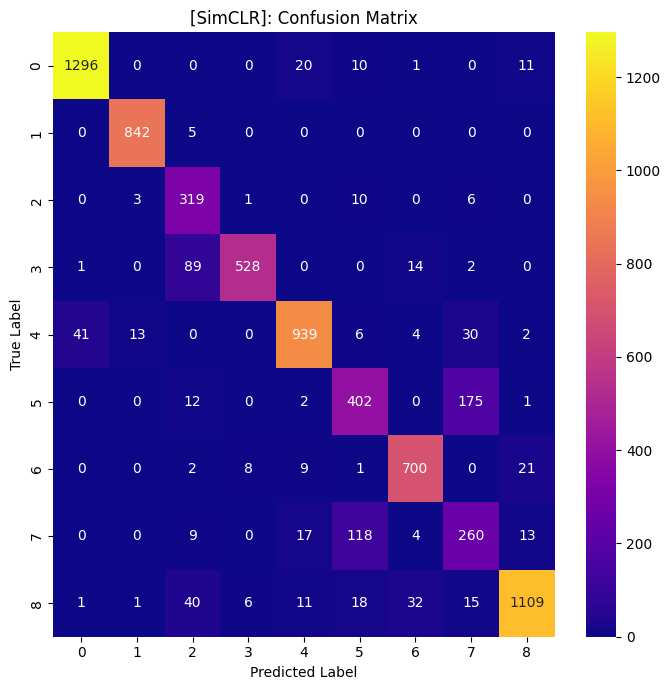

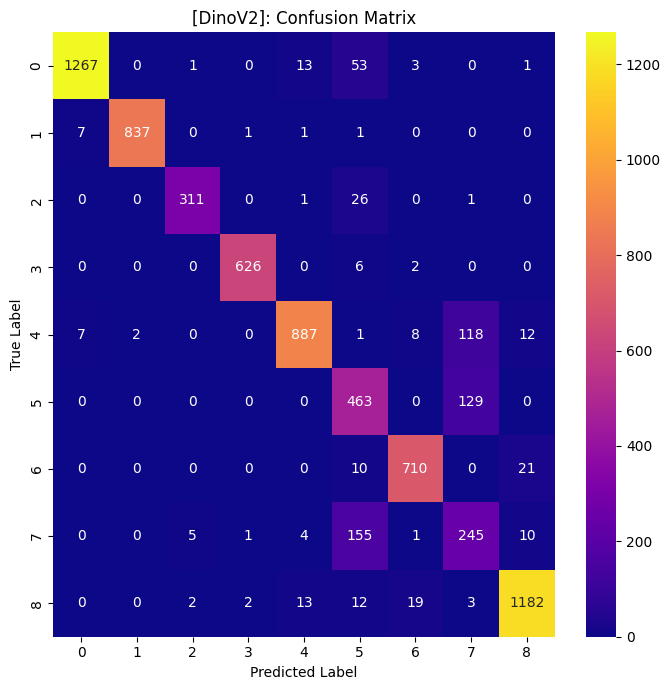

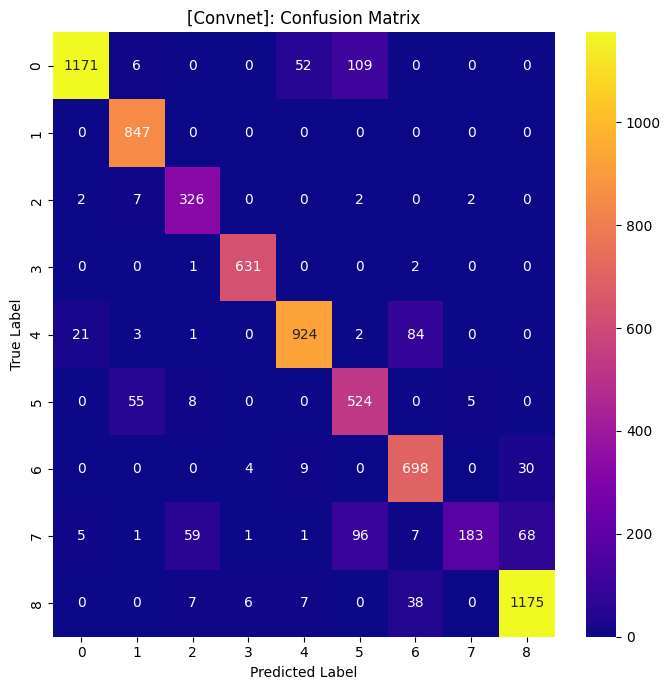

In [31]:
# Confusion!
class_names = probes["Convnet"].classes_

for k, m in metrics.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(
        m["cm"], 
        annot=True,
        fmt="d", 
        cmap="plasma", 
        xticklabels=class_names, 
        yticklabels=class_names, 
        ax=ax,
        cbar=True,
    )
    
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    ax.set_title(f"[{k}]: Confusion Matrix")
    fig.tight_layout()

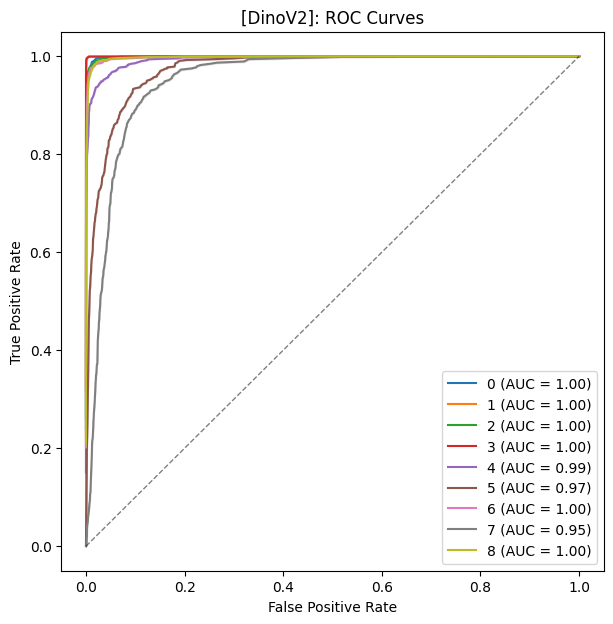

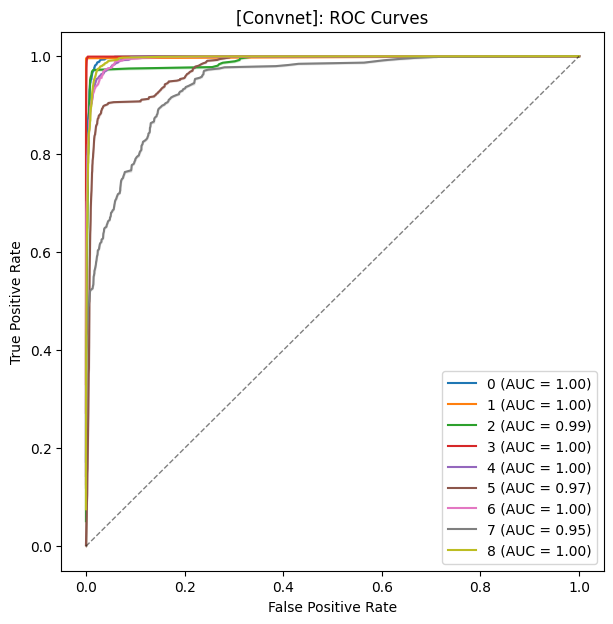

In [33]:
# ROC Curves
n_classes = len(class_names)

for k, m in metrics.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    fpr, tpr, roc_auc, _ = m["roc"]

    for i in range(n_classes):
        sns.lineplot(
            x=fpr[i],
            y=tpr[i],
            lw=1.5,
            label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})",
            ax=ax,
        )     

    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"[{k}]: ROC Curves")
    ax.legend(loc="lower right")

## Cross-Domain Application 🌐
Here’s where the last couple of questions come in:
- How effective is the prototype algorithm in cross-domain knowledge?
- Does initializing ProtoNet with a pre-trained encoder improve cross-domain performance compared to training from scratch?

In this section, I wanted to quantify how effective the embeddings are when classifying an image the model hasn’t seen before.

### The Hiccup 🥲
Originally (and typically), N-way K-shot validation is used: a few image classes are hidden during training and only shown afterward (in-domain). However, due to some oversight, I trained my `SimCLR` encoder on **all** classes. This meant that even if labels were withheld during training, the encoder still learned where to place them - an unfair advantage compared to a properly trained `ConvNet`.

> This wouldn’t be such a problem if `SimCLR` didn’t take so long to train!!

So, instead of struggling with limited compute, I pivoted my exploration to cross-domain applications, which led to the questions above. I chose to use [HMU-GE-HE-30K](https://www.nature.com/articles/s41597-025-04489-9), a dataset of gastric microenvironments. I felt this was close enough to the domain without being too easy or too hard.

### Evaluation 📝
After evaluation, I found that despite never seeing these images, **the models were still able to get some correct answers**. Even more interesting, predictions became more confident as I added more images to the query set. This makes sense - more references help anchor where new samples should be placed. The story gets even more interesting when we visualize the embedding space.

From this analysis, I noticed:
1. **How effective is the prototype algorithm in cross-domain knowledge?**  
   - Not very effective with the methods I tested. However, some works like LDP-Net [(Zhou et al., 2023)](https://openaccess.thecvf.com/content/CVPR2023/papers/Zhou_Revisiting_Prototypical_Network_for_Cross_Domain_Few-Shot_Learning_CVPR_2023_paper.pdf) achieve better performance.  
   - It’s quite a difficult task — evaluation against other models in Zhou et al. (2023) shows it’s common for models to struggle with generalizability.

2. **Does initializing ProtoNet with a pre-trained encoder improve cross-domain performance compared to training from scratch?**  
   - Apparently yes! I can’t make definitive claims, but my small-scale exploration suggests that a pre-trained encoder (SSL, no less) improves ProtoNet performance.  
   - Surprisingly, `SimCLR` on domain-specific data beats `DINO` - you would think the generalist model should perform better! This does suggest to me that we can apply models like these to similar domains and potentially get something useful.

### Follow-Up Work
- Try evaluating `SimCLR` with a further domain dataset like CARS 🚗; I expect `DINO` to perform better here.  
- Experiment with LDP-Net and other modern few-shot methods.  
- Correctly perform N-way K-shot… but hey, at least I learned to be careful!


In [45]:
imagenet_transforms = get_dino_transforms()

test_dataset = TMEData("data/HMU-GE-HE-30K/", transform=imagenet_transforms)
targets = torch.LongTensor([y for _, y in test_dataset.samples])

sampler = FewShotBatchSampler(
        dataset_targets=targets,
        N_way=5,
        K_shot=4,
        shuffle=False,
        include_query=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    num_workers=10, 
    batch_size=128,
    shuffle=False,
    drop_last=False
)

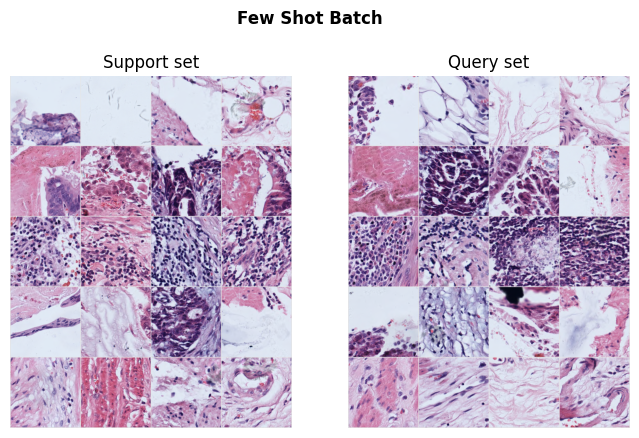

In [46]:
# Peek one episode to demonstrate (code borrowed - UvA)
episode = DataLoader(
    dataset=test_dataset, num_workers=4, batch_sampler=sampler
)

imgs, labels = next(iter(episode))
support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, labels)

support_grid = torchvision.utils.make_grid(support_imgs, nrow=4, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=4, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()

In [47]:
# Code borrowed as well from UvA
@torch.no_grad()
def test_proto_net(encoder, targets, dataloader, data_feats=None, k_shot=4, device="cuda"):
    """Evaluates k-shot; adapted code from UvA notebook"""
    model = encoder.to(device).eval()
    model_name = str(model).split("(")[0]
    num_classes = targets.unique().shape[0]
    exmps_per_class = targets.shape[0] // num_classes
    
    img_features = []
    img_targets = []

    if not data_feats:
        for imgs, targets in tqdm.tqdm(dataloader, f"Extracting image features: {model_name}"):
            imgs = imgs.to(device)
            feats = encoder(imgs)

            if isinstance(feats, tuple):
                _, feats = feats
            
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)

        
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    
    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm.tqdm(range(0, img_features.shape[0], k_shot), f"Evaluating classification: {model_name}"):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = ProtoNet.calculate_prototypes(k_img_feats, k_targets)
        
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = ProtoNet.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (np.mean(accuracies), np.std(accuracies)), (img_features, img_targets)

In [48]:
kshot_metrics = {} # {model: {k: metrics}}

for bbname, bb in backbones.items():
    data_feats = None
    accs = {}
    
    for k in [2, 4, 8, 16, 32]:
        res, data_feats = test_proto_net(
            encoder=bb, 
            targets=targets,
            dataloader=test_dataloader, 
            data_feats=data_feats, 
            k_shot=k
        )

        accs[k] = res

    kshot_metrics[bbname] = accs

Evaluating classification: DenseNet: 100%|██████████████████████████| 122/122 [00:03<00:00, 35.85it/s]


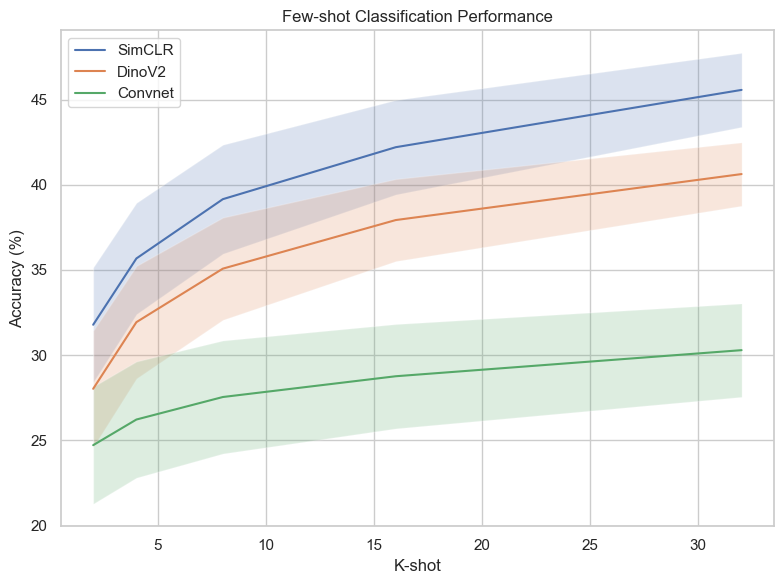

In [49]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

for bbname, results in kshot_metrics.items():
    ks = sorted(results.keys())
    means = np.array([results[k][0] for k in ks]) * 100
    stds = np.array([results[k][1] for k in ks]) * 100
    
    sns.lineplot(x=ks, y=means, label=bbname)
    plt.fill_between(ks, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

plt.xlabel("K-shot")
plt.ylabel("Accuracy (%)")
plt.title("Few-shot Classification Performance")
plt.legend()
plt.tight_layout()
plt.show()

As we can see, `SimCLR` seems to preform marginally better than `DINO` and `Convnet`!

## Visualize Cross-Domain Embeddings 👀

This part was particularly interesting. Here, I pushed images through the encoders to get embeddings and applied the same dimensionality reduction analysis as earlier in the notebook.

Despite the low accuracy, **there still seems to be some structure in the embeddings!** In both UMAP and t-SNE, classes cluster in roughly the same general locations. This lines up with the results above: there’s still some ability to generalize to another domain.

Visually, the `ConvNet` embeddings look the most amalgamated, with less clear structure. In contrast, the other two encoders show more distinct separation between most classes (colors).


In [50]:
def get_prototype(h, y):
    protos, classes = ProtoNet.calculate_prototypes(h, y)
    protos = protos / protos.norm(dim=1, keepdim=True)
    return protos, classes
    
device = "cuda"
gc_embeds = extract_embeddings(backbones, test_dataloader, normalize=True) # {bbname: (h, y)}
protos = {k: get_prototype(h, y) for k, (h, y) in gc_embeds.items()} # {bbname: (proto, cls)}

Extracting Features: 100%|██████████████████████████████████████████| 243/243 [03:29<00:00,  1.16it/s]


In [51]:
# Plot UMAP
RANDOM_STATE_UMAP = 5301
N_NEIGHBORS = 20
MIN_DIST = 0.8

umaps = {}
for k, (embeds, lbls) in gc_embeds.items():
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=N_NEIGHBORS,
        min_dist=MIN_DIST,
        random_state=RANDOM_STATE_UMAP,
    )
    X = reducer.fit_transform(embeds) 

    if k in protos:
        proto_feats, proto_classes = protos[k]
        P = reducer.transform(proto_feats) 
        
    umaps[k] = (X, lbls, P, proto_classes)

C:\Users\Alvin\Desktop\prototype-learning\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Alvin\Desktop\prototype-learning\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Alvin\Desktop\prototype-learning\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


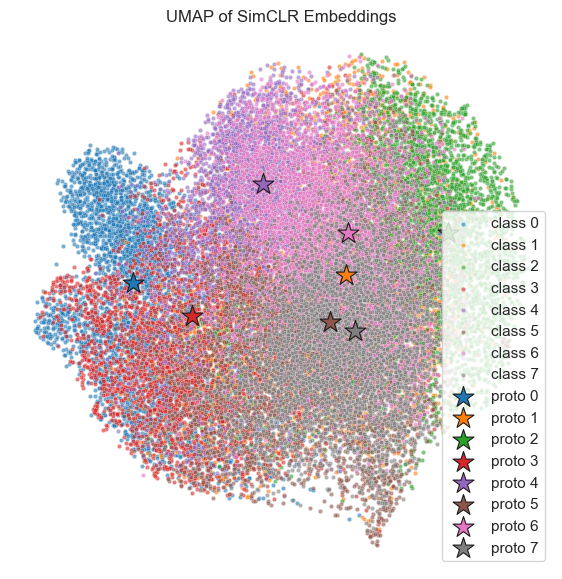

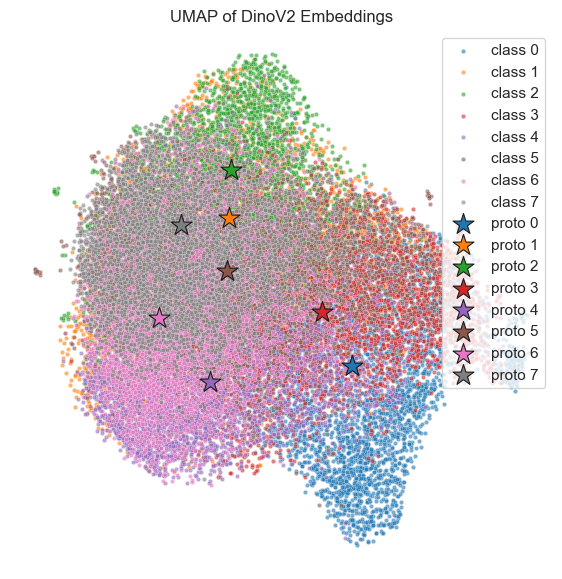

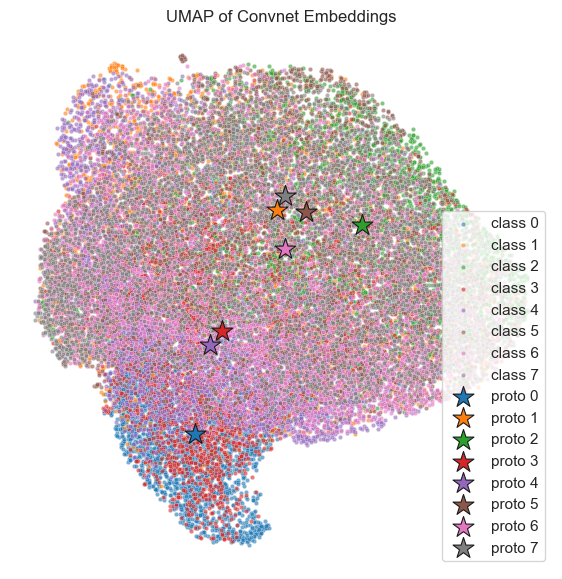

In [52]:
for k, (X, Y, P, proto_classes) in umaps.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    Y = Y.flatten()
    n_classes = len(np.unique(Y))
    palette = sns.color_palette("tab10", n_colors=n_classes)

    # embeddings
    for c in np.unique(Y):
        mask = (Y == c)
        sns.scatterplot(
            x=X[mask, 0], y=X[mask, 1],
            s=10, alpha=0.6,
            label=f"class {int(c)}",
            color=palette[int(c)], ax=ax,
        )

    # prototypes
    if P is not None:
        for i, c in enumerate(proto_classes):
            ax.scatter(
                P[i, 0], P[i, 1],
                marker="*", s=250,
                edgecolors="k", linewidths=0.8,
                color=palette[int(c)], label=f"proto {int(c)}"
            )

    ax.set_title(f"UMAP of {k} Embeddings")
    ax.axis("off")
    ax.legend()

In [53]:
RANDOM_STATE_TSNE = 42
PERPLEXITY = 30

tsnes = {}
for k, (embeds, lbls) in gc_embeds.items():
    proto_feats, proto_classes = protos[k]
    combined = torch.cat([embeds, proto_feats], dim=0).cpu().numpy()
    tsne = TSNE(n_components=2, perplexity=PERPLEXITY, random_state=RANDOM_STATE_TSNE)
    Z = tsne.fit_transform(combined)
    
    X = Z[:len(embeds)]         # embeddings
    P = Z[len(embeds):]         # prototypes

    tsnes[k] = (X, lbls, P, proto_classes)

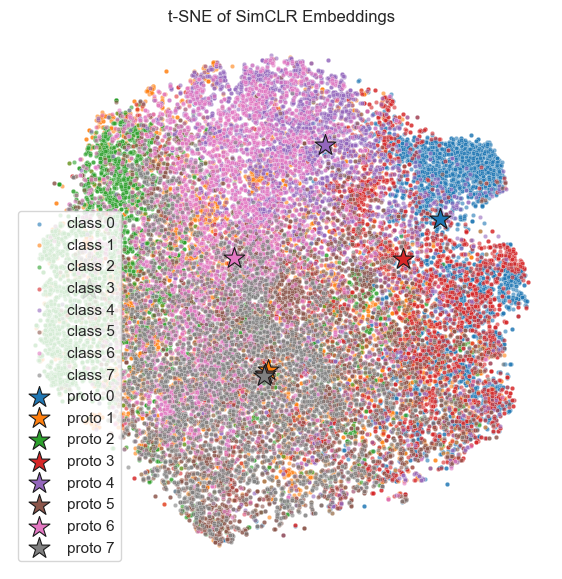

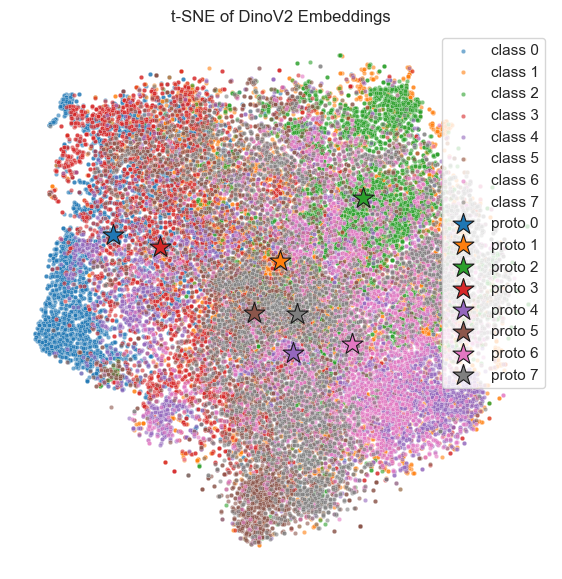

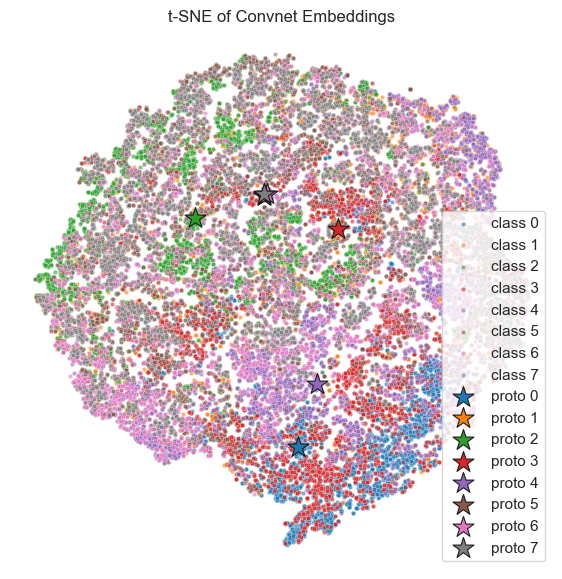

In [54]:
for k, (X, Y, P, proto_classes) in tsnes.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    Y = Y.flatten()
    n_classes = len(np.unique(Y))
    palette = sns.color_palette("tab10", n_colors=n_classes)

    # embeddings
    for c in np.unique(Y):
        mask = (Y == c)
        sns.scatterplot(
            x=X[mask, 0], y=X[mask, 1],
            s=10, alpha=0.6,
            label=f"class {int(c)}",
            color=palette[int(c)], ax=ax,
        )

    # prototypes
    if P is not None:
        for i, c in enumerate(proto_classes):
            ax.scatter(
                P[i, 0], P[i, 1],
                marker="*", s=250,
                edgecolors="k", linewidths=0.8,
                color=palette[int(c)], label=f"proto {int(c)}"
            )

    ax.set_title(f"t-SNE of {k} Embeddings")
    ax.axis("off")
    ax.legend()

## Wrap-Up & Takeaways 🎉

This little exploration started with a curiosity about **self-supervised learning (SSL)** and **meta-learning (ProtoNets)**. I made it a point to try and work on medical datasets, cause that's what's relevant to me. Anyways, along the way, I ran into some hiccups, pivoted directions, and ended up with a better sense of both the strengths and limits of these methods.

### Key Takeaways
- **SSL works well**: Even with a simple linear probe, both `SimCLR` and `DINO` produced embeddings that were highly linearly separable. `DINO` won by a tiny margin but `SimCLR` held its own despite being much smaller, so did `Convnet`.
- **Training cost matters**: `ConvNet` was fast and surprisingly competitive, while `SimCLR` took days to train. Pretrained `DINO` was convenient but compute-heavy to train from scratch. This means that we shouldn't neglect cheaper methods, especially if they get the work done fast and efficiently.
- **Embeddings show structure**: t-SNE and UMAP plots confirmed that classes clustered meaningfully, even in cross-domain data. This suggests some generalization ability, though not perfect.
- **Cross-domain is tough**: ProtoNet struggled when evaluated across domains consistent with findings in literature. That said, initializing with the pretrained encoders gave it a noticeable boost.
- **Domain-specific SimCLR vs. generalist DINO**: Interestingly, `SimCLR` trained on domain data sometimes outperformed the large pretrained `DINO`. It appears to me that generalists don't always win if the target domain is narrow.

### Future Works 🚀
- **Proper N-way K-shot validation**: Re-run few-shot experiments correctly (without the oversight of including all classes in pretraining).
- **Further domain testing**: Try harder shifts (e.g., CARS 🚗 dataset) where I expect `DINO`’s generalist nature to shine more than `SimCLR`.
- **New architectures**: Explore modern few-shot approaches like LDP-Net and those mentioned in [Zhou et al. (2023)](https://openaccess.thecvf.com/content/CVPR2023/papers/Zhou_Revisiting_Prototypical_Network_for_Cross_Domain_Few-Shot_Learning_CVPR_2023_paper.pdf) and compare them.
- **Efficiency vs. performance tradeoffs**: Dive deeper into how training time, compute, and dataset size affect the practical usability of these methods in medical contexts.
- **Clustering**: certain classes in the embeddings space group together in similar regions despite being trained differently; I should investigate if this trend appears elsewhere. Could it be the backbone architecture?
---

Overall, this project gave me a deeper appreciation for how representation learning connects to real-world problems like limited labels in medical imaging. It also reminded me that even "failed" experiments (like my SimCLR oversight) can still lead to new insights and better questions. And that’s a win in itself. 🙌
